In [ ]:
'''
Procedures
1. Generate the ICM spectral model 
(tbabs, CIE (normalization, varying temperature) )
2. Generate photons 
(XMM response file, exposure time)
3. take median energy from the photons
4. plot the median energy versus the temperature

'''

In [ ]:
import numpy as np
import os


# 1. Generate the ICM spectral model 

In [ ]:
'''
1. Generate the ICM spectral model 
Model:
(tbabs, CIE)

Input parameters:
tbabs: nH=1e20 atom cm-2 (in xcop nH < 1e21) -> 0.01 in xspec
apec:  normalization, varying temperature
norm = 6e-4
z = 0.05 (xcop 0.04-0.1)
abundance = 0.3 solar abundance -> 0.3 to aspl
temperature = 0.1-3 keV, with bin 0.1 keV

how is norm decided
11.03-3.62 * 1e-3 suzaku norm at 60 arcmin(~r500)
2.73 -0.62 * 1e-3 suzaku norm at 80 arcmin(~r200)
assume the spectrum extraction region according to A222-223 sp arf
norm = 1.5e-3/400pi * area arcmin2
Tools: 
xspec

'''



In [25]:
'''
1. Load a xcm file in ideal_mdls
'''

T_arr = np.arange(0.6, 3.1, 0.1)
A_arr = np.array([147.69, 178.76, 299.47]) # arcmin2
INST_arr = ['mos1', 'mos2', 'pn'] 
norm_per_am = 1.5e-3/400/np.pi
reds = 0.05
abun = 0.3
nH_arr = [0.08]

os.chdir('/Users/eusracenorth/Documents/work/EXTG/ideal_mdls/bin')

f = open(f'gen_ideal_mdl_vary-T_nH.sh', 'w')
f.write(f'''
xspec << EOT
@../sample_mdls/tot-mdl_nH_1e20_z_005_norm_1_T_1.xcm
''')

for T in T_arr:
    for nH in nH_arr:
        for i, A in enumerate(A_arr):
            INST = INST_arr[i]
            norm = norm_per_am * A
            f.write(f'''
rm ../mdls/ideal-mdl_z_005_suzakunorm_15e-4_{INST}_A{int(A)}_T_{T:.1f}_abun{abun:.1f}_nH{nH:.2f}e22.xcm
abun aspl
new 1 {nH}
new 2 {T}
new 3 {abun}
new 4 {reds}
new 5 {norm}
save mo ../mdls/ideal-mdl_z_005_suzakunorm_15e-4_{INST}_A{int(A)}_T_{T:.1f}_abun{abun:.1f}_nH{nH:.2f}e22.xcm
''')
f.write('EOT')
f.close()


## in command line
# heainit
# sh gen_mdl.sh


# 2. Generate photons 
(XMM response file, exposure time)

Input parameters:
XMM response: MOS and PN 
()
texp = 1e6 s 
Tools:
fakeit

file: bin/mock_spectra.sh


In [ ]:
#!/bin/bash

# Define your input filenames
exposure_time=1000000000             # Replace with your desired exposure time in seconds
output_dir="../mock_spectras"  # Replace with your desired output directory

# Create the output directory if it doesn't exist
mkdir -p "$output_dir"

# Loop through XCM files in the current directory and generate mock spectra
for inst in pn; do # mos1 mos2 pn
resp_file="${output_dir}/${inst}.rmf"  # Replace with your XMM response file
arf_file="${output_dir}/${inst}.arf"

for xspec_model_file in ../mdls/ideal-mdl_z_005_suzakunorm_15e-4_*_A*_T_*_abun0.3_nH0.08e22.xcm; do

# Extract the model name (excluding the .xcm extension) from the file
model_name="$(basename "$xspec_model_file" | sed 's/\.xcm$//')"
# Define the output spectrum filename based on the model name
output_spectrum="$output_dir/mock_spectrum_${model_name}.fak"

# Run XSpec in batch mode to generate the mock spectrum
xspec <<EOF
rm $output_spectrum
rm ${output_spectrum}.log
log >${output_spectrum}.log # no space after >!
data none               # Clear any existing data
@$xspec_model_file # Load the XCM model file
fakeit none
$resp_file  
$arf_file
n

$output_spectrum
$exposure_time, 1, 0
log none
exit
EOF

echo "Mock spectrum for $model_name generated and saved as $output_spectrum"
done
done

3. take median energy from the photons

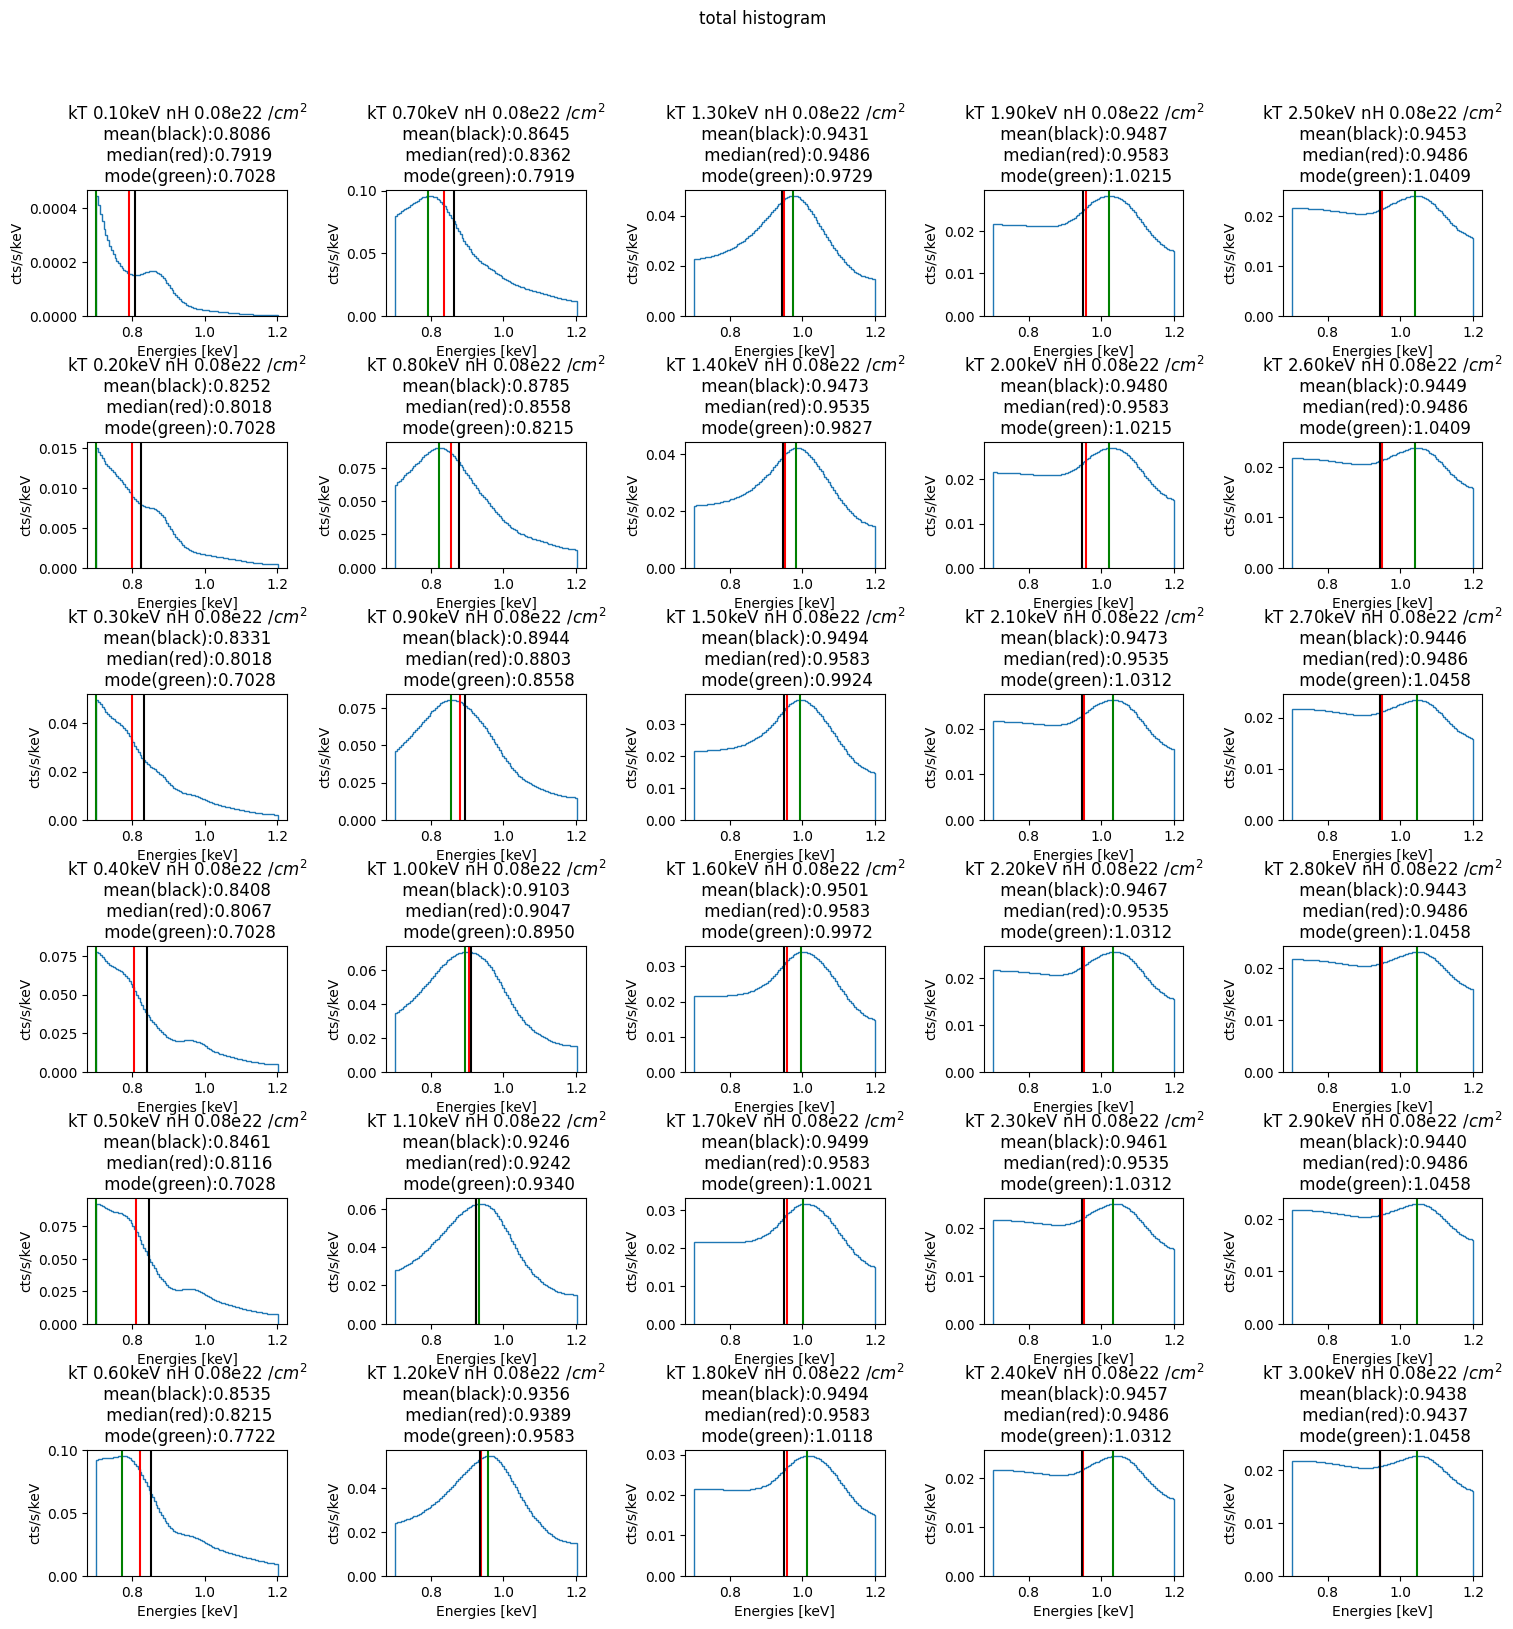

med [0.79194897 0.801799   0.801799   0.80671996 0.81164002 0.82147104
 0.83620203 0.85581499 0.88028902 0.904719   0.92423499 0.93885702
 0.94859898 0.95346802 0.958336   0.958336   0.958336   0.958336
 0.958336   0.958336   0.95346802 0.95346802 0.95346802 0.94859898
 0.94859898 0.94859898 0.94859898 0.94859898 0.94859898 0.94372898]
mean [0.80861753 0.82522005 0.8331399  0.84079844 0.84605271 0.85348386
 0.86448652 0.87853819 0.89438868 0.91027945 0.92456287 0.93561256
 0.94314307 0.94730991 0.94938606 0.95006508 0.94993418 0.94940269
 0.94871843 0.94800538 0.94732296 0.94669938 0.94614458 0.94569582
 0.94529212 0.94492352 0.94460356 0.9443149  0.94404221 0.94380909]


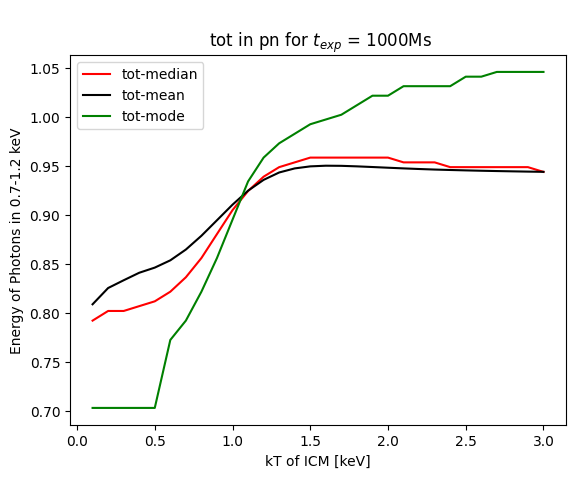

In [27]:
'''
1. load channel to energy in rmf file
2. load spectrum counts in 0.7-1.2 keV
3. cal median of the photons
'''

cb = ['#0173b2', '#de8f05', '#029e73', '#d55e00', '#cc78bc', '#ca9161', '#fbafe4', '#949494', '#ece133', '#56b4e9']

os.chdir(f'/Users/eusracenorth/Documents/work/EXTG/ideal_mdls/mock_spectras')
from astropy.io import fits
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

def most_common_ele_in1darr(arr):
    u, indices, counts = np.unique(arr, return_index = True, return_counts = True)
    return u[np.argmax(counts)]

# Check if all elements are integers
def are_all_integers(arr):
    are_all_integers = np.all(np.mod(arr, 1) == 0)
    # Print the result
    if are_all_integers:
        print("All elements in the array are integers.")
    else:
        print("Not all elements in the array are integers.")
        print(arr)

def ctr2photons_from_spec(filename, time_exp, energy_msk, energy_range):
    fak_file = fits.open(filename)
    ctr = fak_file[1].data['RATE']
    # print(ctr[energy_msk], time_exp)
    # are_all_integers(ctr[energy_msk] * time_exp)
    cts = np.array(ctr[energy_msk] * time_exp).astype(int)
    data_arr = np.repeat(energy_range[:-1], cts)
    
    return data_arr

def gen_photons_for_lines(tot_filename, cont_filename, time_exp, energy_msk, energy_range):
    tot_file = fits.open(tot_filename)
    cont_file = fits.open(cont_filename)
    tot_ctr = tot_file[1].data['RATE']
    cont_ctr = cont_file[1].data['RATE']
    ctr = tot_ctr - cont_ctr
    cts = np.array(ctr[energy_msk] * time_exp).astype(int)
    data_arr = np.repeat(energy_range[:-1], cts)
    return data_arr

# basic parameters
T_arr = np.arange(0.1, 3.1, 0.1)
t_exp = 1000000000
nH = 0.08

for INST in ['pn']: # 'mos1', 'mos2', 'pn'
    # load and filter the energy range
    rmf_file = fits.open(f'{INST}.rmf')
    Elo = rmf_file[2].data['E_MIN']
    Ehi = rmf_file[2].data['E_MAX']
    # print(Elo)
    # filter ctr in 0.7-1.2 keV
    E_msk = (Elo>0.7) & (Elo<1.2)
    E_range = np.append(Elo[E_msk], Ehi[E_msk][-1])

    # initialize  
    result_dict ={}
    for type in ['tot']: # 'tot', 'lines', 'cont'
        result_dict[type] = {}
        for stat in ['med', 'mean', 'sum', 'mode']:
            result_dict[type][stat] = np.zeros(T_arr.shape)
    
    # test the median of continuum
    fig, axs = plt.subplots(6,5, figsize = (18,18), gridspec_kw={'wspace': 0.5, 'hspace': 1.0})
    
    for i, T in enumerate(T_arr):

        tot_filename = glob(f'mock*ideal-mdl_z_005_suzakunorm_15e-4_{INST}_A*_T_{T:.1f}_abun0.3_nH{nH:.2f}e22.fak')[0]

        cts_dir = {}
        cts_dir['tot'] = ctr2photons_from_spec(tot_filename, t_exp, E_msk, E_range)


        hist_data, __ = np.histogram(cts_dir['tot'], bins = E_range)
        axs[int(i%6), int(i//6)].stairs(hist_data/t_exp/np.diff(E_range), E_range)
        axs[int(i%6), int(i//6)].axvline(np.median(cts_dir['tot']), color = 'r')
        axs[int(i%6), int(i//6)].axvline(np.mean(cts_dir['tot']), color = 'k')
        axs[int(i%6), int(i//6)].axvline(most_common_ele_in1darr(cts_dir['tot']), color = 'g')
        axs[int(i%6), int(i//6)].set_ylabel(f'cts/s/keV')
        axs[int(i%6), int(i//6)].set_xlabel(f'Energies [keV]')
        axs[int(i%6), int(i//6)].set_title(f'''kT {T:.2f}keV nH {nH:.2f}e22 /$cm^2$\n mean(black):{np.mean(cts_dir['tot']):.4f} \n median(red):{np.median(cts_dir['tot']):.4f}\n mode(green):{most_common_ele_in1darr(cts_dir['tot']):.4f}''')
        

        for type in ['tot']:
            result_dict[type]['med'][i] = np.median(cts_dir[type])
            result_dict[type]['mean'][i] = np.mean(cts_dir[type])
            result_dict[type]['mode'][i] = most_common_ele_in1darr(cts_dir['tot'])
            result_dict[type]['sum'][i] = np.sum(cts_dir[type])
    plt.suptitle('total histogram')
    plt.show()
    plt.close()


    # make the plot
    for type in ['tot']: # 'tot', 'lines', 'cont'
        fig = plt.subplots()
        plt.plot(T_arr, result_dict[type]['med'], label = f'{type}-median', c = 'r')
        plt.plot(T_arr, result_dict[type]['mean'], label = f'{type}-mean', c = 'k')
        plt.plot(T_arr, result_dict[type]['mode'], label = f'{type}-mode', c = 'g')
        # plt.plot(T_arr, result_dict[type]['sum'], label = f'{type}-sum', c = cb[k])
        print('med', result_dict[type]['med'])
        print('mean', result_dict[type]['mean'])

        plt.title(f'\n {type} in {INST} for $t_{{exp}}$ = 1000Ms')
        # plt.ylabel('Counts [cts]')
        plt.ylabel('Energy of Photons in 0.7-1.2 keV')
        plt.xlabel('kT of ICM [keV]')
        plt.legend()
        plt.show()
        plt.close()

